In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [14]:
CSV_PATH = './gazebo_dataset_01272026/labels_01272026.csv'
IMG_DIR = './gazebo_dataset_01272026/images/'
EDGE_DIR = './gazebo_dataset_01272026/edge_detection_results_01272026/'

In [15]:
df = pd.read_csv(CSV_PATH)
print(f"Total samples: {len(df)}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nDirection counts:\n{df['direction'].value_counts()}")

Total samples: 11876

First few rows:
                               current_image  \
0  Loc0-102ed7ec84c44be3b4066caccff2011e.png   
1  Loc0-102ed7ec84c44be3b4066caccff2011e.png   
2  Loc0-102ed7ec84c44be3b4066caccff2011e.png   
3  Loc0-102ed7ec84c44be3b4066caccff2011e.png   
4  Loc0-102ed7ec84c44be3b4066caccff2011e.png   

                           destination_image direction  
0  Loc0-5107f16132e14cbbae95826a39aa0643.png     right  
1  Loc0-ad13f58f6f9549b48af9a145c8398fde.png     right  
2  Loc9-fb497088983647238d06767871bef8f7.png  backward  
3  Loc9-057e8f35ac974ad487b4ca23310cb397.png  backward  
4  Loc9-15467f62ac4f489194c3adb5d3fea27e.png  backward  

Direction counts:
direction
forward     3030
backward    3018
left        2925
right       2903
Name: count, dtype: int64


In [16]:
direction_map = {'forward': 0, 'backward': 1, 'left': 2, 'right': 3}
df['direction_label'] = df['direction'].map(direction_map)
print(f"first few rows after direction mapping:\n{df.head()}")

first few rows after direction mapping:
                               current_image  \
0  Loc0-102ed7ec84c44be3b4066caccff2011e.png   
1  Loc0-102ed7ec84c44be3b4066caccff2011e.png   
2  Loc0-102ed7ec84c44be3b4066caccff2011e.png   
3  Loc0-102ed7ec84c44be3b4066caccff2011e.png   
4  Loc0-102ed7ec84c44be3b4066caccff2011e.png   

                           destination_image direction  direction_label  
0  Loc0-5107f16132e14cbbae95826a39aa0643.png     right                3  
1  Loc0-ad13f58f6f9549b48af9a145c8398fde.png     right                3  
2  Loc9-fb497088983647238d06767871bef8f7.png  backward                1  
3  Loc9-057e8f35ac974ad487b4ca23310cb397.png  backward                1  
4  Loc9-15467f62ac4f489194c3adb5d3fea27e.png  backward                1  


In [17]:
# Shuffle rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [18]:
image_cache = {}

def load_image_cached(img_path):
    if img_path not in image_cache:
        img = load_img(img_path, target_size=(128, 128))
        img = img_to_array(img) / 255.0
        image_cache[img_path] = img
    return image_cache[img_path]

In [19]:
def create_dataset(dataframe, image_dir, batch_size=32):
    current_images = []
    dest_images = []
    labels = []
    suffix = ''
    if image_dir == EDGE_DIR:
        suffix = '_hed'
        
    for idx, row in dataframe.iterrows():
        current_img = load_image_cached(image_dir + row['current_image'][:-4] + suffix + '.png')
        dest_img = load_image_cached(image_dir + row['destination_image'][:-4] + suffix + '.png')

        current_images.append(current_img)
        dest_images.append(dest_img)
        labels.append(row['direction_label'])

    current_images = np.array(current_images)
    dest_images = np.array(dest_images)
    labels = np.array(labels)

    return current_images, dest_images, labels

In [20]:
def rgb_encoder(input_shape):
    inp = Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(96, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    return models.Model(inp, x, name="RGB_Encoder")


In [21]:
def hed_encoder(input_shape):
    inp = Input(shape=input_shape)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    return models.Model(inp, x, name="HED_Encoder")


In [22]:
def build_siamese_model(H=128, W=128):
    # Inputs
    current_rgb = Input(shape=(H, W, 3))
    current_hed = Input(shape=(H, W, 3))
    dest_rgb = Input(shape=(H, W, 3))
    dest_hed = Input(shape=(H, W, 3))

    rgb_enc = rgb_encoder((H, W, 3))
    hed_enc = hed_encoder((H, W, 3))

    curr_feat = layers.Concatenate()([
        rgb_enc(current_rgb),
        hed_enc(current_hed)
    ])

    
    dest_feat = layers.Concatenate()([
        rgb_enc(dest_rgb),
        hed_enc(dest_hed)
    ])

    
    diff = layers.Subtract()([dest_feat, curr_feat])
    abs_diff = layers.Lambda(lambda x: tf.abs(x))(diff)

    final_feat = layers.Concatenate()([
        curr_feat, dest_feat, diff, abs_diff
    ])

    x = layers.Dense(256, activation='relu')(final_feat)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(4, activation='softmax')(x)

    model = models.Model(
        inputs=[current_rgb, current_hed, dest_rgb, dest_hed],
        outputs=output
    )

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [23]:
def federated_average(models):
    weights = [m.get_weights() for m in models]
    new_weights = []

    for layer_weights in zip(*weights):
        new_weights.append(
            np.mean(np.stack(layer_weights, axis=0), axis=0)
        )

    return new_weights


In [24]:
cv_results = []
num_rounds = 23

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

fold_accuracy = []
num_clients = 2
local_epochs = 1

hed_freeze_round = 16
rgb_freeze_round = 20

cv_prec = np.zeros((K, num_rounds // 5))
cv_rec  = np.zeros((K, num_rounds // 5))
cv_f1   = np.zeros((K, num_rounds // 5))

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\n================ CV Fold {fold_idx+1}/{K} ================\n")

    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df   = df.iloc[val_idx].reset_index(drop=True)
    
    shard_size = len(train_df) // num_clients
    client_train_data = []

    for i in range(num_clients):
        start = i * shard_size
        end = start + shard_size if i < num_clients - 1 else len(train_df)
        
        # Get shard in original order
        shard = df.iloc[start:end]

        print(f"\nClient: {i+1}")
        print("Loading training data...")
        X_train_current, X_train_dest, y_train = create_dataset(shard, IMG_DIR)
        
        X_train_current_hed, X_train_dest_hed, _ = create_dataset(shard, EDGE_DIR)
        
        client_train_data.append(
            (X_train_current, X_train_dest, X_train_current_hed, X_train_dest_hed, y_train)
        )

        print(f"\nTraining data shapes:")
        print(f"Current images: {X_train_current.shape}")
        print(f"Destination images: {X_train_dest.shape}")
        print(f"Labels: {y_train.shape}")

    print("Loading global validation data...")
    X_val_current, X_val_dest, y_val = create_dataset(val_df, IMG_DIR)
    X_val_current_hed, X_val_dest_hed, _ = create_dataset(val_df, EDGE_DIR)

    global_model = build_siamese_model()


    client_models = []
    for _ in range(num_clients):
        m = build_siamese_model()
        m.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        client_models.append(m)

    round_accuracy = []
    
    for round_idx in range(num_rounds):
        
        print(f"\n===== Federated Round {round_idx+1} =====")
    
        if round_idx == rgb_freeze_round:
            print("Freezing encoders and recompiling models")
    
            for m in client_models:
                m.get_layer("RGB_Encoder").trainable = False
    
                m.compile(
                    optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )
    
            global_model.get_layer("RGB_Encoder").trainable = False
    
            global_model.compile(
                optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            
        if round_idx == hed_freeze_round:
            print("Freezing encoders and recompiling models")
    
            for m in client_models:
                m.get_layer("HED_Encoder").trainable = False
    
                m.compile(
                    optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )
    
            global_model.get_layer("HED_Encoder").trainable = False
    
            global_model.compile(
                optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
    
        global_weights = global_model.get_weights()
        # Braodcast weights
        for m in client_models:
            m.set_weights(global_weights)
    
        # Local training
        for i in range(num_clients):
            print(f"Training model for client {i+1}")
            X_train_current, X_train_dest, X_train_current_hed, X_train_dest_hed, y_train = client_train_data[i]
            client_models[i].fit(
            [
                X_train_current,
                X_train_current_hed,
                X_train_dest,
                X_train_dest_hed
            ],
            y_train,
            epochs=local_epochs,
            batch_size=16
        )
        
        # Aggregate
        global_model.set_weights(
            federated_average(client_models)
        )

        # Take the model accuracy for some rounds for each CV fold
        if (round_idx+1) % 5 == 0:
            val_loss, val_acc = global_model.evaluate(
                [X_val_current, X_val_current_hed, X_val_dest, X_val_dest_hed],
                y_val,
                verbose=0
            )
            round_accuracy.append(val_acc)
            y_pred_probs = global_model.predict(
                [X_val_current, X_val_current_hed, X_val_dest, X_val_dest_hed],
                verbose=0
            )
            
            y_pred = np.argmax(y_pred_probs, axis=1)
            
            cv_prec[fold_idx, round_idx//5] = precision_score(y_val, y_pred, average='weighted')
            cv_rec[fold_idx, round_idx//5] = recall_score(y_val, y_pred, average='weighted')
            cv_f1[fold_idx, round_idx//5] = f1_score(y_val, y_pred, average='weighted')
    
    # Save the model accuracy for some rounds for each CV fold
    fold_accuracy.append(round_accuracy)

    val_loss, val_acc = global_model.evaluate(
        [X_val_current, X_val_current_hed, X_val_dest, X_val_dest_hed],
        y_val,
        verbose=0
    )

    print(f"Fold {fold_idx+1} Accuracy: {val_acc:.4f}")
    cv_results.append(val_acc)



================ CV Fold 1/5 ================


Client: 1
Loading training data...

Training data shapes:
Current images: (4750, 128, 128, 3)
Destination images: (4750, 128, 128, 3)
Labels: (4750,)

Client: 2
Loading training data...

Training data shapes:
Current images: (4750, 128, 128, 3)
Destination images: (4750, 128, 128, 3)
Labels: (4750,)
Loading global validation data...


===== Federated Round 1 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 81s 260ms/step - accuracy: 0.2613 - loss: 1.4007
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 80s 260ms/step - accuracy: 0.2634 - loss: 1.4031

===== Federated Round 2 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 80s 269ms/step - accuracy: 0.3061 - loss: 1.3653
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 80s 268ms/step - accuracy: 0.2924 - loss: 1.3688

===== Federated Round 3 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 78s 262ms/step - accuracy: 0.3223 - loss:

C:\Users\tedro\anaconda3\envs\cnn_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



===== Federated Round 6 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 78s 262ms/step - accuracy: 0.2526 - loss: 1.3864
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 79s 266ms/step - accuracy: 0.2479 - loss: 1.3862

===== Federated Round 7 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 77s 261ms/step - accuracy: 0.2484 - loss: 1.3863
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 78s 263ms/step - accuracy: 0.2570 - loss: 1.3861

===== Federated Round 8 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 77s 259ms/step - accuracy: 0.2547 - loss: 1.3863
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 76s 257ms/step - accuracy: 0.2496 - loss: 1.3861

===== Federated Round 9 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 77s 260ms/step - accuracy: 0.2451 - loss: 1.3864
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 79s 267ms/step - accuracy: 0.2570 - loss: 1.3861

===== Federated Round 10 ==

C:\Users\tedro\anaconda3\envs\cnn_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



===== Federated Round 11 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 76s 257ms/step - accuracy: 0.2518 - loss: 1.3863
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 76s 257ms/step - accuracy: 0.2515 - loss: 1.3861

===== Federated Round 12 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 77s 258ms/step - accuracy: 0.2537 - loss: 1.3863
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 77s 259ms/step - accuracy: 0.2538 - loss: 1.3861

===== Federated Round 13 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 77s 260ms/step - accuracy: 0.2543 - loss: 1.3863
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 78s 261ms/step - accuracy: 0.2574 - loss: 1.3861

===== Federated Round 14 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 78s 263ms/step - accuracy: 0.2465 - loss: 1.3863
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 78s 264ms/step - accuracy: 0.2515 - loss: 1.3860

===== Federated Round 1

C:\Users\tedro\anaconda3\envs\cnn_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



===== Federated Round 16 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 76s 256ms/step - accuracy: 0.2531 - loss: 1.3864
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 76s 257ms/step - accuracy: 0.2570 - loss: 1.3861

===== Federated Round 17 =====
Freezing encoders and recompiling models
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 63s 206ms/step - accuracy: 0.2516 - loss: 1.3864
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 64s 208ms/step - accuracy: 0.2475 - loss: 1.3861

===== Federated Round 18 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - accuracy: 0.2465 - loss: 1.3863
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - accuracy: 0.2511 - loss: 1.3861

===== Federated Round 19 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 64s 215ms/step - accuracy: 0.2480 - loss: 1.3863
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 207ms/step - accuracy: 0.251

C:\Users\tedro\anaconda3\envs\cnn_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



===== Federated Round 21 =====
Freezing encoders and recompiling models
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.2543 - loss: 1.3863
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.2461 - loss: 1.3861

===== Federated Round 22 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.2522 - loss: 1.3863
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.2461 - loss: 1.3860

===== Federated Round 23 =====
Training model for client 1
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.2423 - loss: 1.3863
Training model for client 2
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.2555 - loss: 1.3861
Fold 2 Accuracy: 0.2598

================ CV Fold 3/5 ================


Client: 1
Loading training data...

Training data shapes:
Current images: (4750, 128, 128, 3)
Destination images: (4750, 128, 128, 3)
Labels: (4750,)

Client: 2

In [26]:
print("\n========== CV RESULTS ==========")
print(f"Mean Accuracy: {np.mean(cv_results):.4f}")
print(f"Std Accuracy : {np.std(cv_results):.4f}")


========== CV RESULTS ==========
Mean Accuracy: 0.7804
Std Accuracy : 0.2603


Bar chart of CV accuracy per fold, Acc, precision, f1 score, recall of global model, and Fold accuracy for each fold and each round

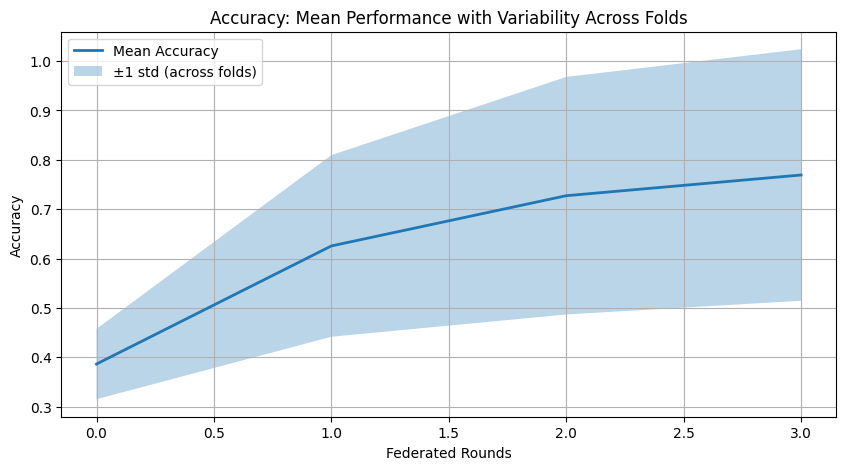

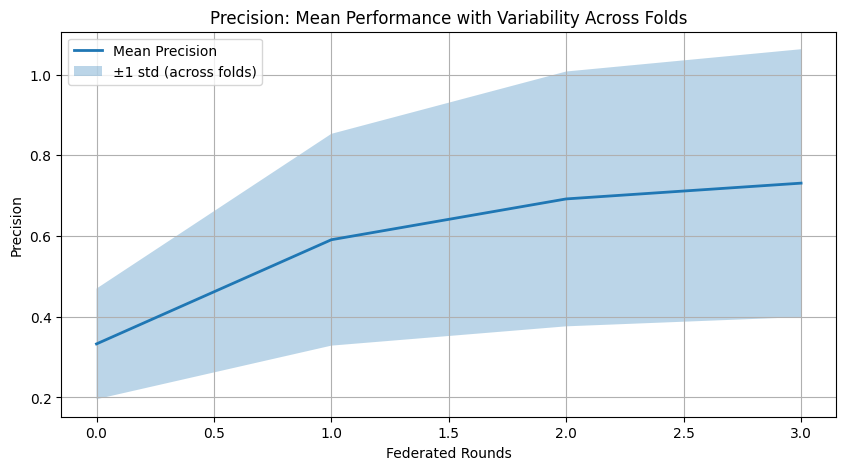

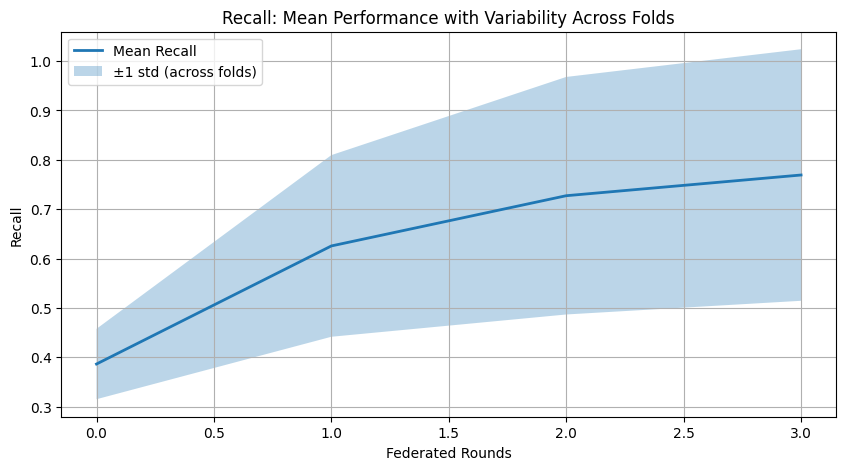

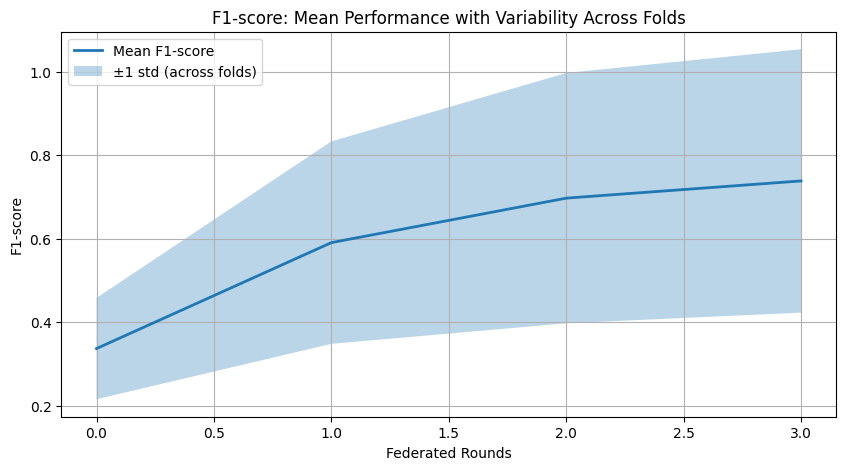

In [30]:
import matplotlib.pyplot as plt

def plot_mean_std(metric, name):
    mean = metric.mean(axis=0)
    std = metric.std(axis=0)
    rounds = np.arange(len(mean))

    plt.figure(figsize=(10, 5))
    plt.plot(rounds, mean, linewidth=2, label=f"Mean {name}")
    plt.fill_between(
        rounds,
        mean - std,
        mean + std,
        alpha=0.3,
        label="±1 std (across folds)"
    )
    plt.xlabel("Federated Rounds")
    plt.ylabel(name)
    plt.title(f"{name}: Mean Performance with Variability Across Folds")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_mean_std(np.array(fold_accuracy), "Accuracy")
plot_mean_std(cv_prec, "Precision")
plot_mean_std(cv_rec, "Recall")
plot_mean_std(cv_f1, "F1-score")


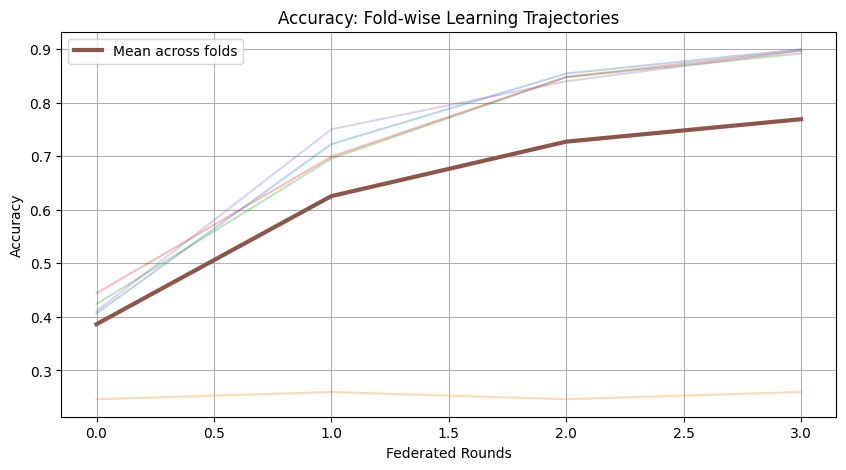

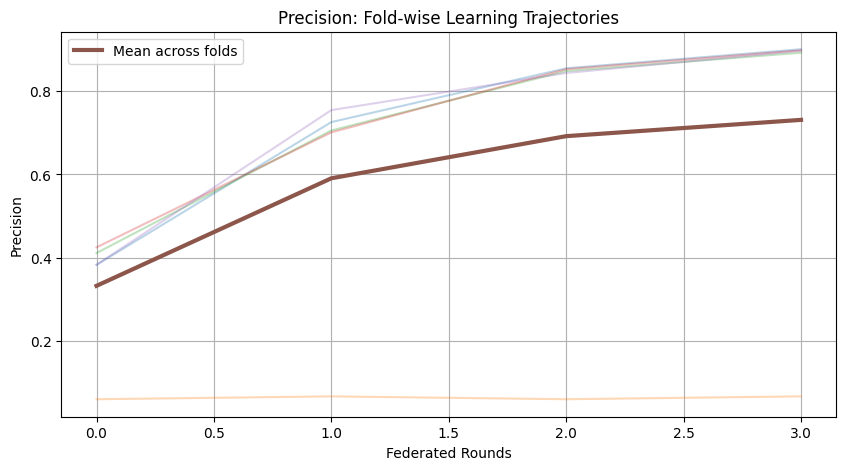

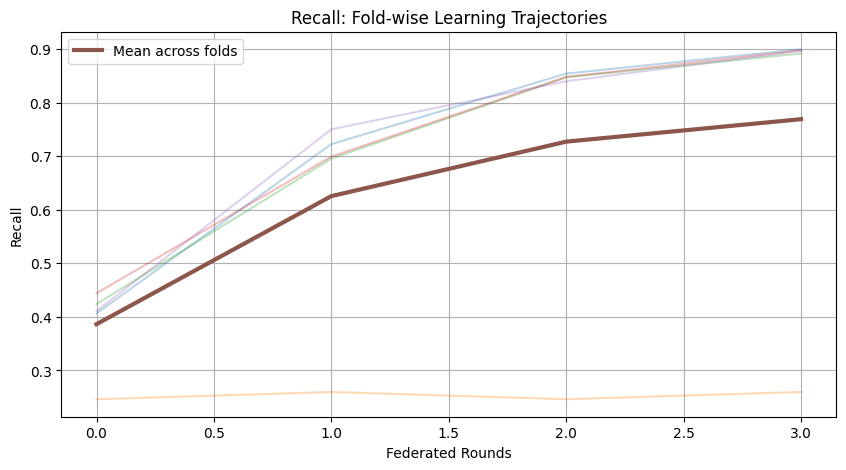

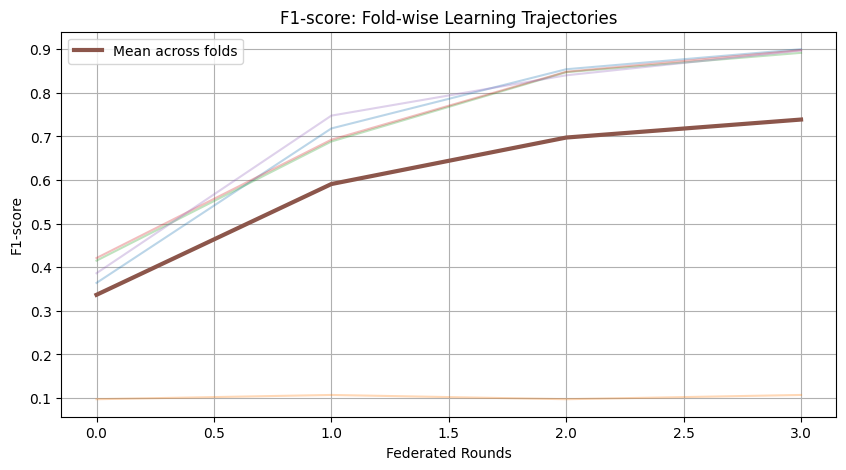

In [32]:
def plot_fold_trajectories(metric, name):
    rounds = np.arange(metric.shape[1])

    plt.figure(figsize=(10, 5))

    # Individual folds (faint)
    for k in range(metric.shape[0]):
        plt.plot(rounds, metric[k], alpha=0.3)

    # Mean (bold)
    plt.plot(
        rounds,
        metric.mean(axis=0),
        linewidth=3,
        label="Mean across folds"
    )

    plt.xlabel("Federated Rounds")
    plt.ylabel(name)
    plt.title(f"{name}: Fold-wise Learning Trajectories")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_fold_trajectories(np.array(fold_accuracy), "Accuracy")
plot_fold_trajectories(cv_prec, "Precision")
plot_fold_trajectories(cv_rec, "Recall")
plot_fold_trajectories(cv_f1, "F1-score")
